# IPC gas fees mechanism simulation


We show here a simplified simulation of the IPC checkpointing/cross-net transaction fee mechanism we have proposed **here**


Our model takes as an input the external demand for gas usage, and using a model for user value preferences, outputs the trajectory of base fees.

We assume there is one rootnet, and $N$ identical subnets, that can process the same amount of gas. 

## Modelling demand for gas usage

#### Value distribution
We assume that value assigned to a given transaction is drawn from an exponential distribution, with cumulative distribution,
$$F(v)=1-e^{-\lambda v}$$

This means, that only a fraction $F(v)$ of users are willing to pay the $v$ per unit of gas. We chose an exponential function here, but it could be modeled by some other monotonically non-increasing function.

We can parametrize the value distribution for the rootnet and the subnets differently, with a lower $\lambda$ for the rootnet, meaning that users of the rootnet typically asign more value to their transactions. 

Below we define the distributions for the rootnet, and for each of the $N$ subnets, with different parameters.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## define the value cumulative distributions, with different lambdas for rootnet and subnets

#rootnet distribution
lamr=.27

def FFr(v):
    return 1-np.exp(-lamr*v)


#subnets distribution
lams=.3
def FFs(v):
    return 1-np.exp(-lams*v)





#### Generating mempools randomly from demand driving curve
We now define the distributions to draw the mempool size given a certain demand. We'll use a simple Gamma distribution.

For a given target block size, $B^T$ and a given demand $D_t$, we model the demand for using the rootnet based on the current basefees for rootnet and subnet usage, as well as the parameters descibing the value distributions of rootnet vs. subnet users.

We define the base fee for rootnet gas as $b_r$, and the base fee for the subnets as $b_N$. We use the assumption that of the gas usage in subnets, a percentage $g_{ch}$ has to be paid for checkpointing at the rootnet, and a percentage $g_{cr}$ is paid at the rootnet for cross-net transactdions.

If all of the demand for gas usage can be accomodated by the rootnet alone, then we assign all of the demand as going to the rootnet. Once demand exceeds the capacity of the rootnet, the additional demand is distributed between the rootnet and subnets, weighted by the parameters of the value distribution, giving a slight preference of users for using the rootnet, even if at a higher price. This demand is normalized so that the total demand adds up to $D_t$.

We draw the mempool size for the rootnet as
$$M_{t}^r\sim {\rm Random}\left(B^T+(D_t-B^T)\frac{1}{b_r\lambda_r}\left(\frac{1}{\frac{1}{b_r\lambda_r}+\frac{1}{((g_{ch}+g_{cr})*b_r+b_N)\lambda_N}}\right)\right),$$
for $D_t>B^T$.
$$M_{t}^r\sim {\rm Random}(D_t)$$
for $D_t\le B^T$.

We draw the mempool for the $N$ subnets as
$$M_t^N\sim{\rm Random}\left( ( D_t-B^T)\frac{1}{((g_{ch}+g_{cr})*b_r+b_N)\lambda_N}\left(\frac{1}{\frac{1}{b_r\lambda_r}+\frac{1}{((g_{ch}+g_{cr})*b_r+b_N)\lambda_N}}\right)\right),$$
for $D_t>B^T$.
$$M_t^N=0$$
for $D_t\le B^T$.


The mempools are drawn using this demand as the parameter for some random distribution. Here we will use a Gamma distribution with mean and variance equal to this demand

In [2]:
#We have total demand D for the whole hierarchy, here we model how much demand will go to rootnet vs subnets.


## distribution for mempool for Rootnet



#define argument for poisson for rootnet
#fraction gch of subnet gas will be checkpointed
#fraction gcr of subnet gas will be used for cross-net transactions
def poissargr(D,B,br,bc,bn,bcr,lamr,lamc,gch,gcr):
    if D>B:
        return B+(D-B)*(1/(1/(br*lamr)+1/((gch*bc+bn+gcr*(br+bcr))*lamc)))*1/(br*lamr)
    else:
        return D
    
#mempool or rootnet
def memr(D,B,br,bc,bn,bcr,lamr,lamc,gch,gcr):
    
    memr=np.random.gamma(poissargr(D,B,br,bc,bn,bcr,lamr,lamc,gch,gcr),1)
    return memr
    #return poissargr(D,B,br,bc,lamr,lamc)

#define argument for Poisson for subnets
def poissargs(D,B,br,bc,bn,bcr,lamr,lamc,gch,gcr):
    if D>B:
        return (D-B)*(1/(1/(br*lamr)+1/((gch*bc+br+gcr*(br+bcr))*lamc)))*1/((gch*bc+bn+gcr*(br+bcr))*lamc)
    else:
        return 0

#mempool for subnets
def mems(D,B,br,bc,bn,bcr,lamr,lamc,gch,gcr):
    
    mems=np.random.gamma(poissargs(D,B,br,bc,bn,bcr,lamr,lamc,gch,gcr),1)
    return mems
    #return poissargs(D,B,br,bc,lamr,lamc)


#### Generating block sizes from mempool sizes
Now we need to calculate the total block sizes, given a mempool and a value distribution, and given current base fees,
* Calculate rootnet regular usage block size,
$$B_{t}^r=M_{t}^r\left[1-F^r(b_t^r)\right].$$
* Calculate sum of blocksize of all subnets
$$B_{t}^N=M_{t}^N\left[1-F^N(b_t^N+(g_{ch}+g_{cr})*b_t^r)\right]$$
This amount of gas is then distributed equally amongst the $N$ subnets.

In [3]:
#Block size for rootnet, given a mempool and a base fee
def Br(Mr,br):
    return Mr*(1-FFr(br))

#Block size for subnets, given a mempool and a base fee
def BN(MN,bN,gch,br,gcr,bcr):
    return MN*(1-FFs(bN+gch*br+gcr*(bcr+br)))

# Checkpointing block size
def Bch(BN,gch):
    return gch*BN

#cross net block size

def Bcr(BN,gcr):
    return gcr*BN



## Updating rules

We assume the rootnet and each of the subnets adjust their base fees according to the EIP-1559 rule.

We also assume an update rule for the cross-net transaction fee mechanism, as proposed *here*.



In [4]:
# define updating functions




#1559 for rootnet
def EIPr(Br,BN,gch,gcr,BT):
    return 1+(1/8)*((Br+BN*(gch+gcr)-BT)/BT)

# update rule for cross-net transaction fee
                    
def EIPcr(O1,O2,Bcr1,Bcr2,BT):
    DeltaO=O1-O2
    DeltaBcr= Bcr1-Bcr2              
    return 1+acr*np.sign(DeltaO*DltaBcr)

# 1559 rule for each subnet

def EIPN(BN,BT,N):
    return 1+(1/8)*(BN/N-BT)/BT

#### Initializing simulation values

We will define some demand function, $D_t$ and initial set of parameters,
* The checkpointing rate $g_{ch}$, which is an assumption that a fraction $g_{ch}$ of all gas usage from subnets will  be consumed at the rootnet for checkpointing.
* The cross-net rate $g_{cr}$, which is an assumption that a fraction $g_{cr}$ of all gas usage from subnets will  be consumed at the rootnet for cross-net transactions.
* The initial rootnet regular base fee, $b_0^r$.
* The initial subnet average base fee $b_0^N$.
* The initial number of subnets $N_0$
* The parameter for the cross-net fee updating rule $a_{cr}$, controlling the step size for adjusting cross-net transaction fees.




In [5]:
# Length of the simulation
L=5000

x=np.arange(0,L)

##### THIS IS WHERE WE CHOOSE OUR DEMAND DRIVING FUNCTION#####

# CONSTANT DEMAND

D=50*np.ones(L)
#Note that regime change transition seems to happen around 71.2
##### Can have other time-variable demand as well


#Checkpointing rate
gch=.01

#Crossnet transaction rate
gcr=0.01

#initial base fees
br0=1
bN0=1
#initial cross net fee
bcr0=1
bch0=1


#initial number of subnets
N0=3.

# parameter for updating function
acr=1/16

#target blocksize
BT=1.
# This means gas is normalized in units of the target block size.



In [6]:
#define output vectors

brL=np.zeros(L)
#bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
bcrL=np.zeros(L)


BBr=np.zeros(L)
BBN=np.zeros(L)
BBch=np.zeros(L)
BBcr=np.zeros(L)
    
brL[0]=br0
#bchL[0]=bch0
bNL[0]=bN0
bcrL[0]=bcr0
bcrL[1]=bcr0
NL[0]=N0
#a[0]=a0
#a[1]=a1

Mr=np.zeros(L)
Ms=np.zeros(L)

### Objective function

We define now the objective function that the cross-net transaction mechanism is trying to maximize. In this simple model this will be the total token burn at the rootnet:
$$\mathcal{O}=b^r(B^r+(g_{ch}+g_{cr})B^N)$$

In the real world we'd propose maximizing a more comprehensive target that doesn't only include the total token burn, but accounts for other important value metrics for Filecoin, such as total network power, and token locked in IPC. 

In [7]:
def Deltatarg1(br1,br2,Br1,Br2,bcr1,bcr2,BN1,BN2,gch,gcr,acr):
    return (br1*(Br1+(gch+gcr)*BN1)-br2*(Br2+(gch+gcr)*BN2))

def Deltatarg2(br1,br2,Br1,Br2,bcr1,bcr2,BN1,BN2,gch,gcr,acr,alpha):
    return (br1*(Br1+(gch+gcr)*BN1)-br2*(Br2+(gch+gcr)*BN2))+(br1*((gch+gcr)*BN1))**alpha-(br2*((gch+gcr)*BN2))**alpha



def fa(Deltatarg,BN1,BN2,gcr,acr):
    
    
    G= gcr*(BN1-BN2)
    

    return acr*np.sign(Deltatarg*G)


## Main loop

Here we run the main loop of our simulation. For each time step, 
* we begin by generating the given mempools for rootnet and subnet gas usage, given the external demand and current base fees and user preferences
* Using this mempool size and current base fees, we calculate the actual realized block size.
* With the actual block sizes, update rules are used to compute next base fee, and next cross-net transaction fees.
* The number of subnets, $N$ is adjusted to either $N-1,N,$ or $N+1$, by choosing the value that is likely to maximize total subnet revenue at the next epoch.

The outputs of the simulation are:

* A sequence of base fees for the rootnet and the subnets.
* A sequence of total network revenue for rootnet and subnet.
* A sequence of optimal hierarchy size, $N$. 

In [8]:
#run stuff!

#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memr(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    Ms[l]=mems(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],gch,brL[l],gcr,bcrL[l])
    BBch[l]=Bch(BBN[l],gch)
    BBcr[l]=Bcr(BBN[l],gcr)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],BBN[l],gch,gcr,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    #a[l+1]=0.5
    #deltaL=Deltatarg1(brL[l],brL[l-1],BBr[l],BBr[l-1],bcrL[l],bcrL[l-1],BBN[l],BBN[l-1],gch,gcr,acr)
    #ffa[l]=fa(DeltaL,BBN[l],BBN[l-1],gcr,acr)
    #bcrL[l+1]=1+ffa[l]*bcrL[l]
    
    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        NL[l+1]=1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        B3=BN(Ms[l],b3,gch,bch,gcr,bcrL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2,
                                       b3*B3-bch*gch*B3-(bch+bcrL[l])*gcr*B3]))
    
  
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memr(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    Ms[l]=mems(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],gch,brL[l],gcr,bcrL[l])
    BBch[l]=Bch(BBN[l],gch)
    BBcr[l]=Bcr(BBN[l],gcr)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],BBN[l],gch,gcr,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    if NL[l]==0:
        bNL[l+1]=0
    else:
        bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    deltaL=Deltatarg1(brL[l],brL[l-1],BBr[l],BBr[l-1],bcrL[l],bcrL[l-1],BBN[l],BBN[l-1],gch,gcr,acr)
    ffa[l]=fa(deltaL,BBN[l],BBN[l-1],gcr,acr)
    bcrL[l+1]=(1+ffa[l])*bcrL[l]
  
    
    if NL[l]==0:
        NL[l+1]=1
        
    #elif NL[l]==1:
       # b1=EIPN(BBN[l],BT,1)*bNL[l]
       # b2=EIPN(BBN[l],BT,2)*bNL[l]
        #bch=brL[l]
        #B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        #B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        #NL[l+1]=1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2])
        
    elif NL[l]==1:
       # b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bch=brL[l]
        #B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        B3=BN(Ms[l],b3,gch,bch,gcr,bcrL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([0,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2,
                                       b3*B3-bch*gch*B3-(bch+bcrL[l])*gcr*B3]))
    

    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        B3=BN(Ms[l],b3,gch,bch,gcr,bcrL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2,
                                       b3*B3-bch*gch*B3-(bch+bcrL[l])*gcr*B3]))
    
  

Total rootnet token burn is 93456.68356309291
92.29443166052499


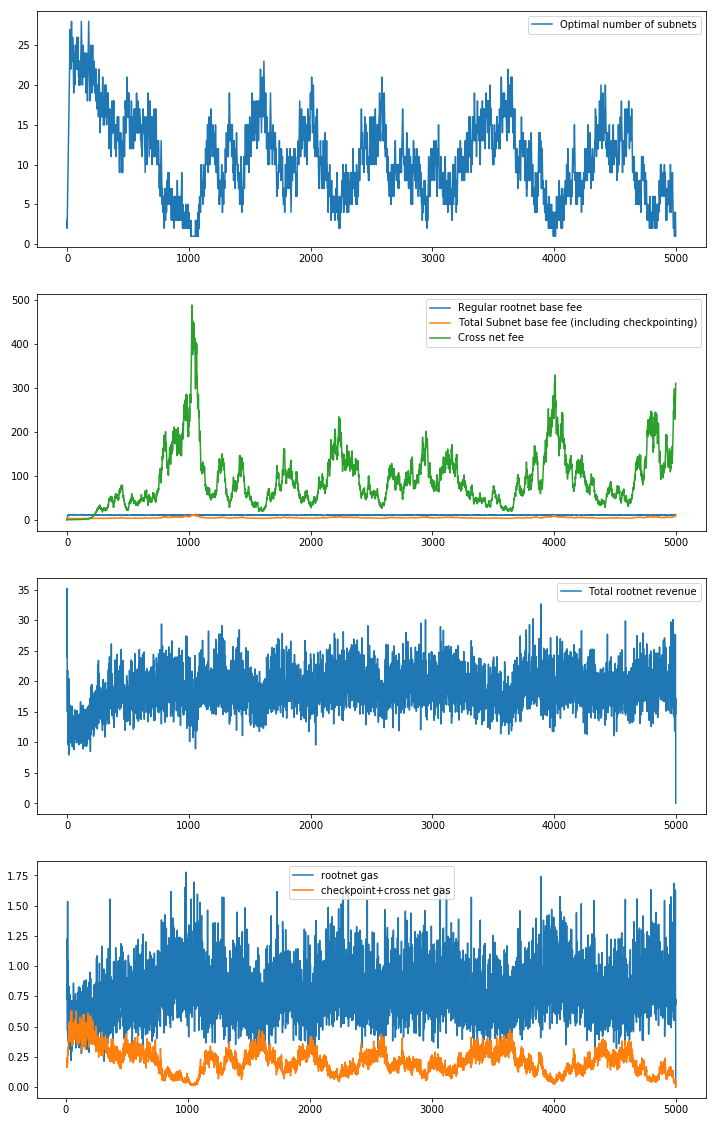

In [9]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()



axs[1].plot(x,brL,label="Regular rootnet base fee")
axs[1].plot(x,gch*brL+bNL+gcr*(brL+bcrL),label="Total Subnet base fee (including checkpointing)")
axs[1].plot(x,bcrL,label="Cross net fee")
axs[1].legend()

axs[2].plot(x,brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN,label="Total rootnet revenue")
axs[2].legend()


axs[3].plot(x[10:],BBr[10:],label="rootnet gas")
axs[3].plot(x[10:],(gch+gcr)*BBN[10:],label="checkpoint+cross net gas")
axs[3].legend()


rone=brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN
#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN))
print(np.mean(bcrL))

## The same simulation but without an explicit cross-net fee mechanism

This simulation repeats the same steps as above, but without an explicit cross-net transaction fee (only regular rootnet gas is paid)

In [10]:
##WITHOUT CROSS NET FEE MECHANISM

#generate mempools

ffa=np.zeros(L)
bcrL=np.zeros(L)
#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memr(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    Ms[l]=mems(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],gch,brL[l],gcr,bcrL[l])
    BBch[l]=Bch(BBN[l],gch)
    BBcr[l]=Bcr(BBN[l],gcr)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],BBN[l],gch,gcr,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    #a[l+1]=0.5
    #deltaL=Deltatarg1(brL[l],brL[l-1],BBr[l],BBr[l-1],bcrL[l],bcrL[l-1],BBN[l],BBN[l-1],gch,gcr,acr)
    #ffa[l]=fa(DeltaL,BBN[l],BBN[l-1],gcr,acr)
    #bcrL[l+1]=1+ffa[l]*bcrL[l]
    
    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        NL[l+1]=1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        B3=BN(Ms[l],b3,gch,bch,gcr,bcrL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2,
                                       b3*B3-bch*gch*B3-(bch+bcrL[l])*gcr*B3]))
    
  
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memr(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    Ms[l]=mems(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],gch,brL[l],gcr,bcrL[l])
    BBch[l]=Bch(BBN[l],gch)
    BBcr[l]=Bcr(BBN[l],gcr)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],BBN[l],gch,gcr,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        NL[l+1]=1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        B3=BN(Ms[l],b3,gch,bch,gcr,bcrL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2,
                                       b3*B3-bch*gch*B3-(bch+bcrL[l])*gcr*B3]))
    
  

Total rootnet token burn is 60483.90575240726
0.0


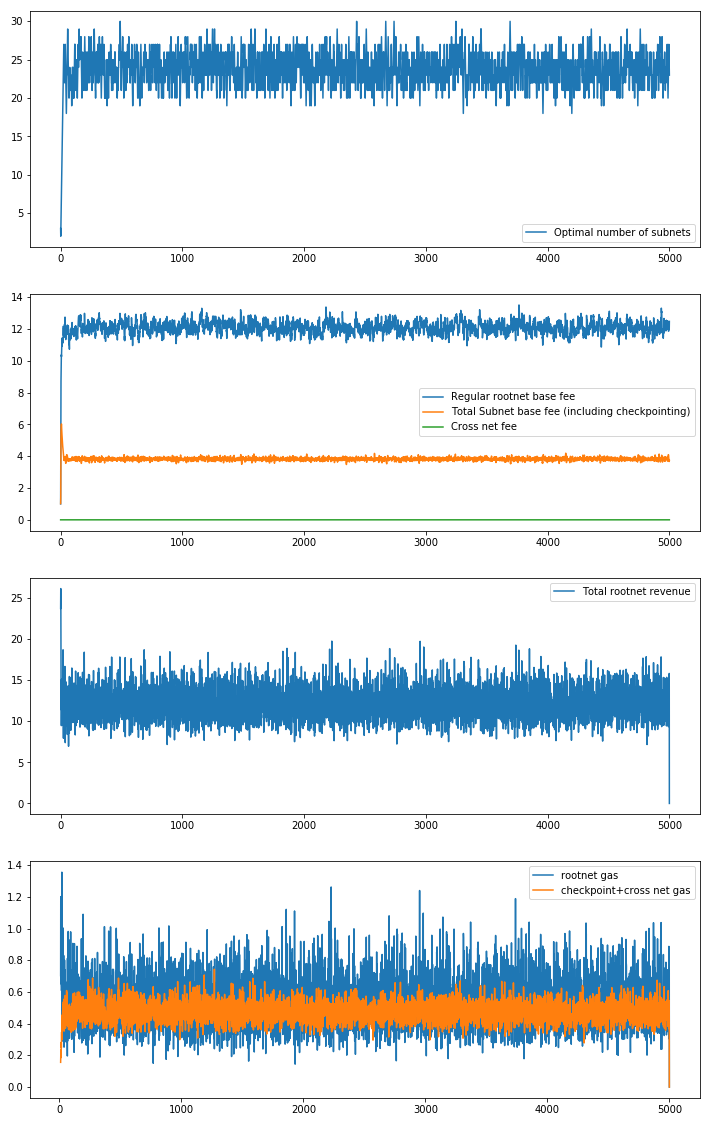

In [11]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()



axs[1].plot(x,brL,label="Regular rootnet base fee")
axs[1].plot(x,gch*brL+bNL+gcr*(brL+bcrL),label="Total Subnet base fee (including checkpointing)")
axs[1].plot(x,bcrL,label="Cross net fee")
axs[1].legend()

axs[2].plot(x,brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN,label="Total rootnet revenue")
axs[2].legend()

axs[3].plot(x[10:],BBr[10:],label="rootnet gas")
axs[3].plot(x[10:],(gch+gcr)*BBN[10:],label="checkpoint+cross net gas")
axs[3].legend()

rtwo=brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN
#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN))
print(np.mean(bcrL))

In [16]:
# with different target
alpha=4
bcrL[0]=bcr0
bcrL[1]=bcr0
#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memr(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    Ms[l]=mems(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],gch,brL[l],gcr,bcrL[l])
    BBch[l]=Bch(BBN[l],gch)
    BBcr[l]=Bcr(BBN[l],gcr)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],BBN[l],gch,gcr,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    #a[l+1]=0.5
    #deltaL=Deltatarg1(brL[l],brL[l-1],BBr[l],BBr[l-1],bcrL[l],bcrL[l-1],BBN[l],BBN[l-1],gch,gcr,acr)
    #ffa[l]=fa(DeltaL,BBN[l],BBN[l-1],gcr,acr)
    #bcrL[l+1]=1+ffa[l]*bcrL[l]
    
    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        NL[l+1]=1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        B3=BN(Ms[l],b3,gch,bch,gcr,bcrL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2,
                                       b3*B3-bch*gch*B3-(bch+bcrL[l])*gcr*B3]))
    
  
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memr(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    Ms[l]=mems(D[l],BT,brL[l],brL[l],bNL[l],bcrL[l],lamr,lams,gch,gcr)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],gch,brL[l],gcr,bcrL[l])
    BBch[l]=Bch(BBN[l],gch)
    BBcr[l]=Bcr(BBN[l],gcr)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],BBN[l],gch,gcr,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    deltaL=Deltatarg2(brL[l],brL[l-1],BBr[l],BBr[l-1],bcrL[l],bcrL[l-1],BBN[l],BBN[l-1],gch,gcr,acr,alpha)
    ffa[l]=fa(deltaL,BBN[l],BBN[l-1],gcr,acr)
    bcrL[l+1]=(1+ffa[l])*bcrL[l]
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        NL[l+1]=1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bch=brL[l]
        B1=BN(Ms[l],b1,gch,bch,gcr,bcrL[l])
        B2=BN(Ms[l],b2,gch,bch,gcr,bcrL[l])
        B3=BN(Ms[l],b3,gch,bch,gcr,bcrL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bch*gch*B1-(bch+bcrL[l])*gcr*B1,b2*B2-bch*gch*B2-(bch+bcrL[l])*gcr*B2,
                                       b3*B3-bch*gch*B3-(bch+bcrL[l])*gcr*B3]))
    
  

Total rootnet token burn is 88457.02770073051
314.12301189245426


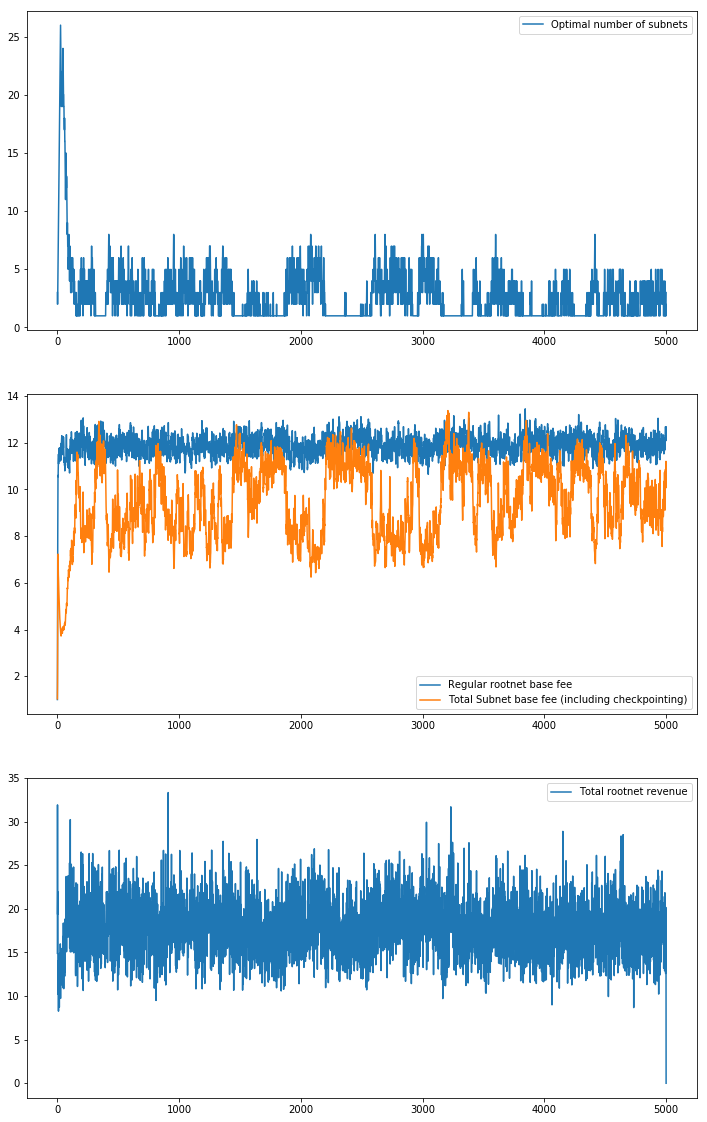

In [19]:
fig, axs = plt.subplots( 3,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()



axs[1].plot(x,brL,label="Regular rootnet base fee")
axs[1].plot(x,gch*brL+bNL+gcr*(brL+bcrL),label="Total Subnet base fee (including checkpointing)")

axs[1].legend()

axs[2].plot(x,brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN,label="Total rootnet revenue")
axs[2].legend()

rthree=brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN

#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+gch*brL*BBN+gcr*(brL+bcrL)*BBN))
print(np.mean(bcrL))

## Comparing total network revenue

Finally we can plot the trajectories of total rootnet revenue with the cross-net transaction fee and without the cross-net transaction fees.

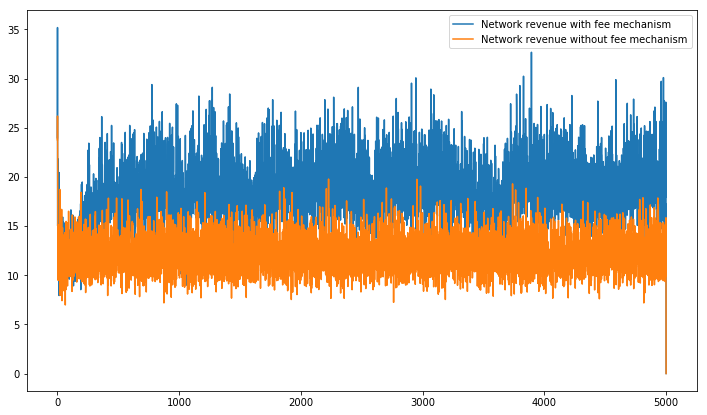

In [18]:
fig, axs = plt.subplots( 1,1,figsize=(12, 7))

axs.plot(x,rone,label='Network revenue with fee mechanism')
axs.plot(x,rtwo,label='Network revenue without fee mechanism')
axs.legend()